At the end of the experiment: 

1. Apply Matthew D Zeiler, Rob Fergus approach to visualize CNNs
2. Apply  Mahendran and Vedaldi approach to visualize CNNs
3. Visualize the learned representations at each layer from the network 


#### 1. Load the model and see its architecture

In [ ]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torchvision import models
from torchvision import transforms, utils

import numpy as np
import scipy.misc
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image

model = models.vgg16(pretrained=True)
print(model.features)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth



Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_s

#### We will load all the module details in a list 

In [ ]:
modules = list(model.features.modules())
modules = modules[1:]
print(modules,"\n\n")
print("third module = ", modules[2])

[Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1

### 2. Load and preprocess an image to pass as input to the network

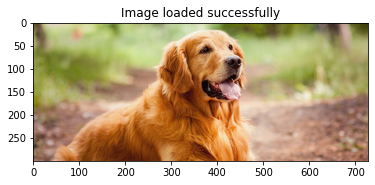

In [ ]:
def normalize(image):
    normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
    )
    preprocess = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    normalize
    ])
    image = Variable(preprocess(image).unsqueeze(0))
    return image

img_raw = Image.open("dog.jpg")
plt.imshow(img_raw)
plt.title("Image loaded successfully")

img = normalize(img_raw)

### 3. Visualize the kernel weights at each layer

(#filters, i/p depth, size of filter) ===  torch.Size([64, 64, 3, 3])
No. of filters:  64


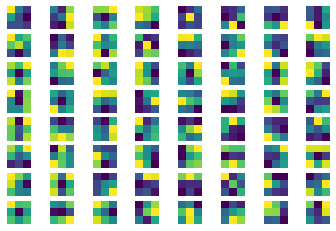

In [ ]:
def visualize_weights(image, layer):
    weight_used = []
    
    ## Gather all Convolution layers and append their corresponding filters in a list
    for w in model.features.children():
        if isinstance(w, torch.nn.modules.conv.Conv2d):
            weight_used.append(w.weight.data)

    print("(#filters, i/p depth, size of filter) === ",weight_used[layer].shape)
    print("No. of filters: ", weight_used[layer].shape[0])
    filters = []
    for i in range(weight_used[layer].shape[0]):
        filters.append(weight_used[layer][i,:,:,:].sum(dim=0))    ##summing across input depth(3 in the first layer)
        filters[i].div(weight_used[layer].shape[1])
        
    fig = plt.figure()
    plt.rcParams["figure.figsize"] = (10, 10)
    for i in range(int(np.sqrt(weight_used[layer].shape[0])) * int(np.sqrt(weight_used[layer].shape[0]))):
        a = fig.add_subplot(np.sqrt(weight_used[layer].shape[0]),np.sqrt(weight_used[layer].shape[0]),i+1)
        imgplot = plt.imshow(filters[i])
        plt.axis('off')

visualize_weights(img, 1)

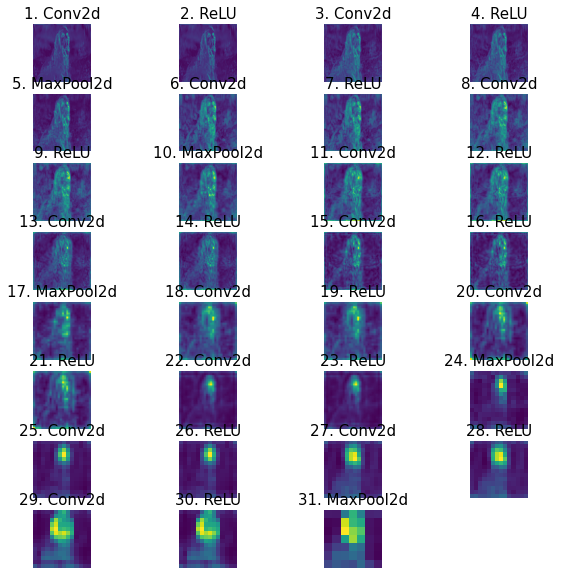

In [ ]:
def to_grayscale(image):
    image = torch.sum(image, dim=0)
    image = torch.div(image, image.shape[0])
    return image

def layer_outputs(image):
    outputs = []
    names = []
    
    ## feed forward the image through the network and store the outputs
    for layer in modules:
        image = layer(image) 
        outputs.append(image)
        names.append(str(layer))
    
    ## for visualization purposes, convert the output into a 2D image by averaging across the filters.
    output_im = []
    for i in outputs:
        i = i.squeeze(0)
        temp = to_grayscale(i)  ## convert say 64x112x112 to 112x112
        output_im.append(temp.data.numpy())
        
    fig = plt.figure()
    plt.rcParams["figure.figsize"] = (30, 40)


    for i in range(len(output_im)):
        a = fig.add_subplot(8,4,i+1)
        imgplot = plt.imshow(output_im[i])
        plt.axis('off')
        a.set_title(str(i+1)+". "+names[i].partition('(')[0], fontsize=15)

#     ##save the resulting visualization
#     plt.savefig('layer_outputs.jpg', bbox_inches='tight')

layer_outputs(img)

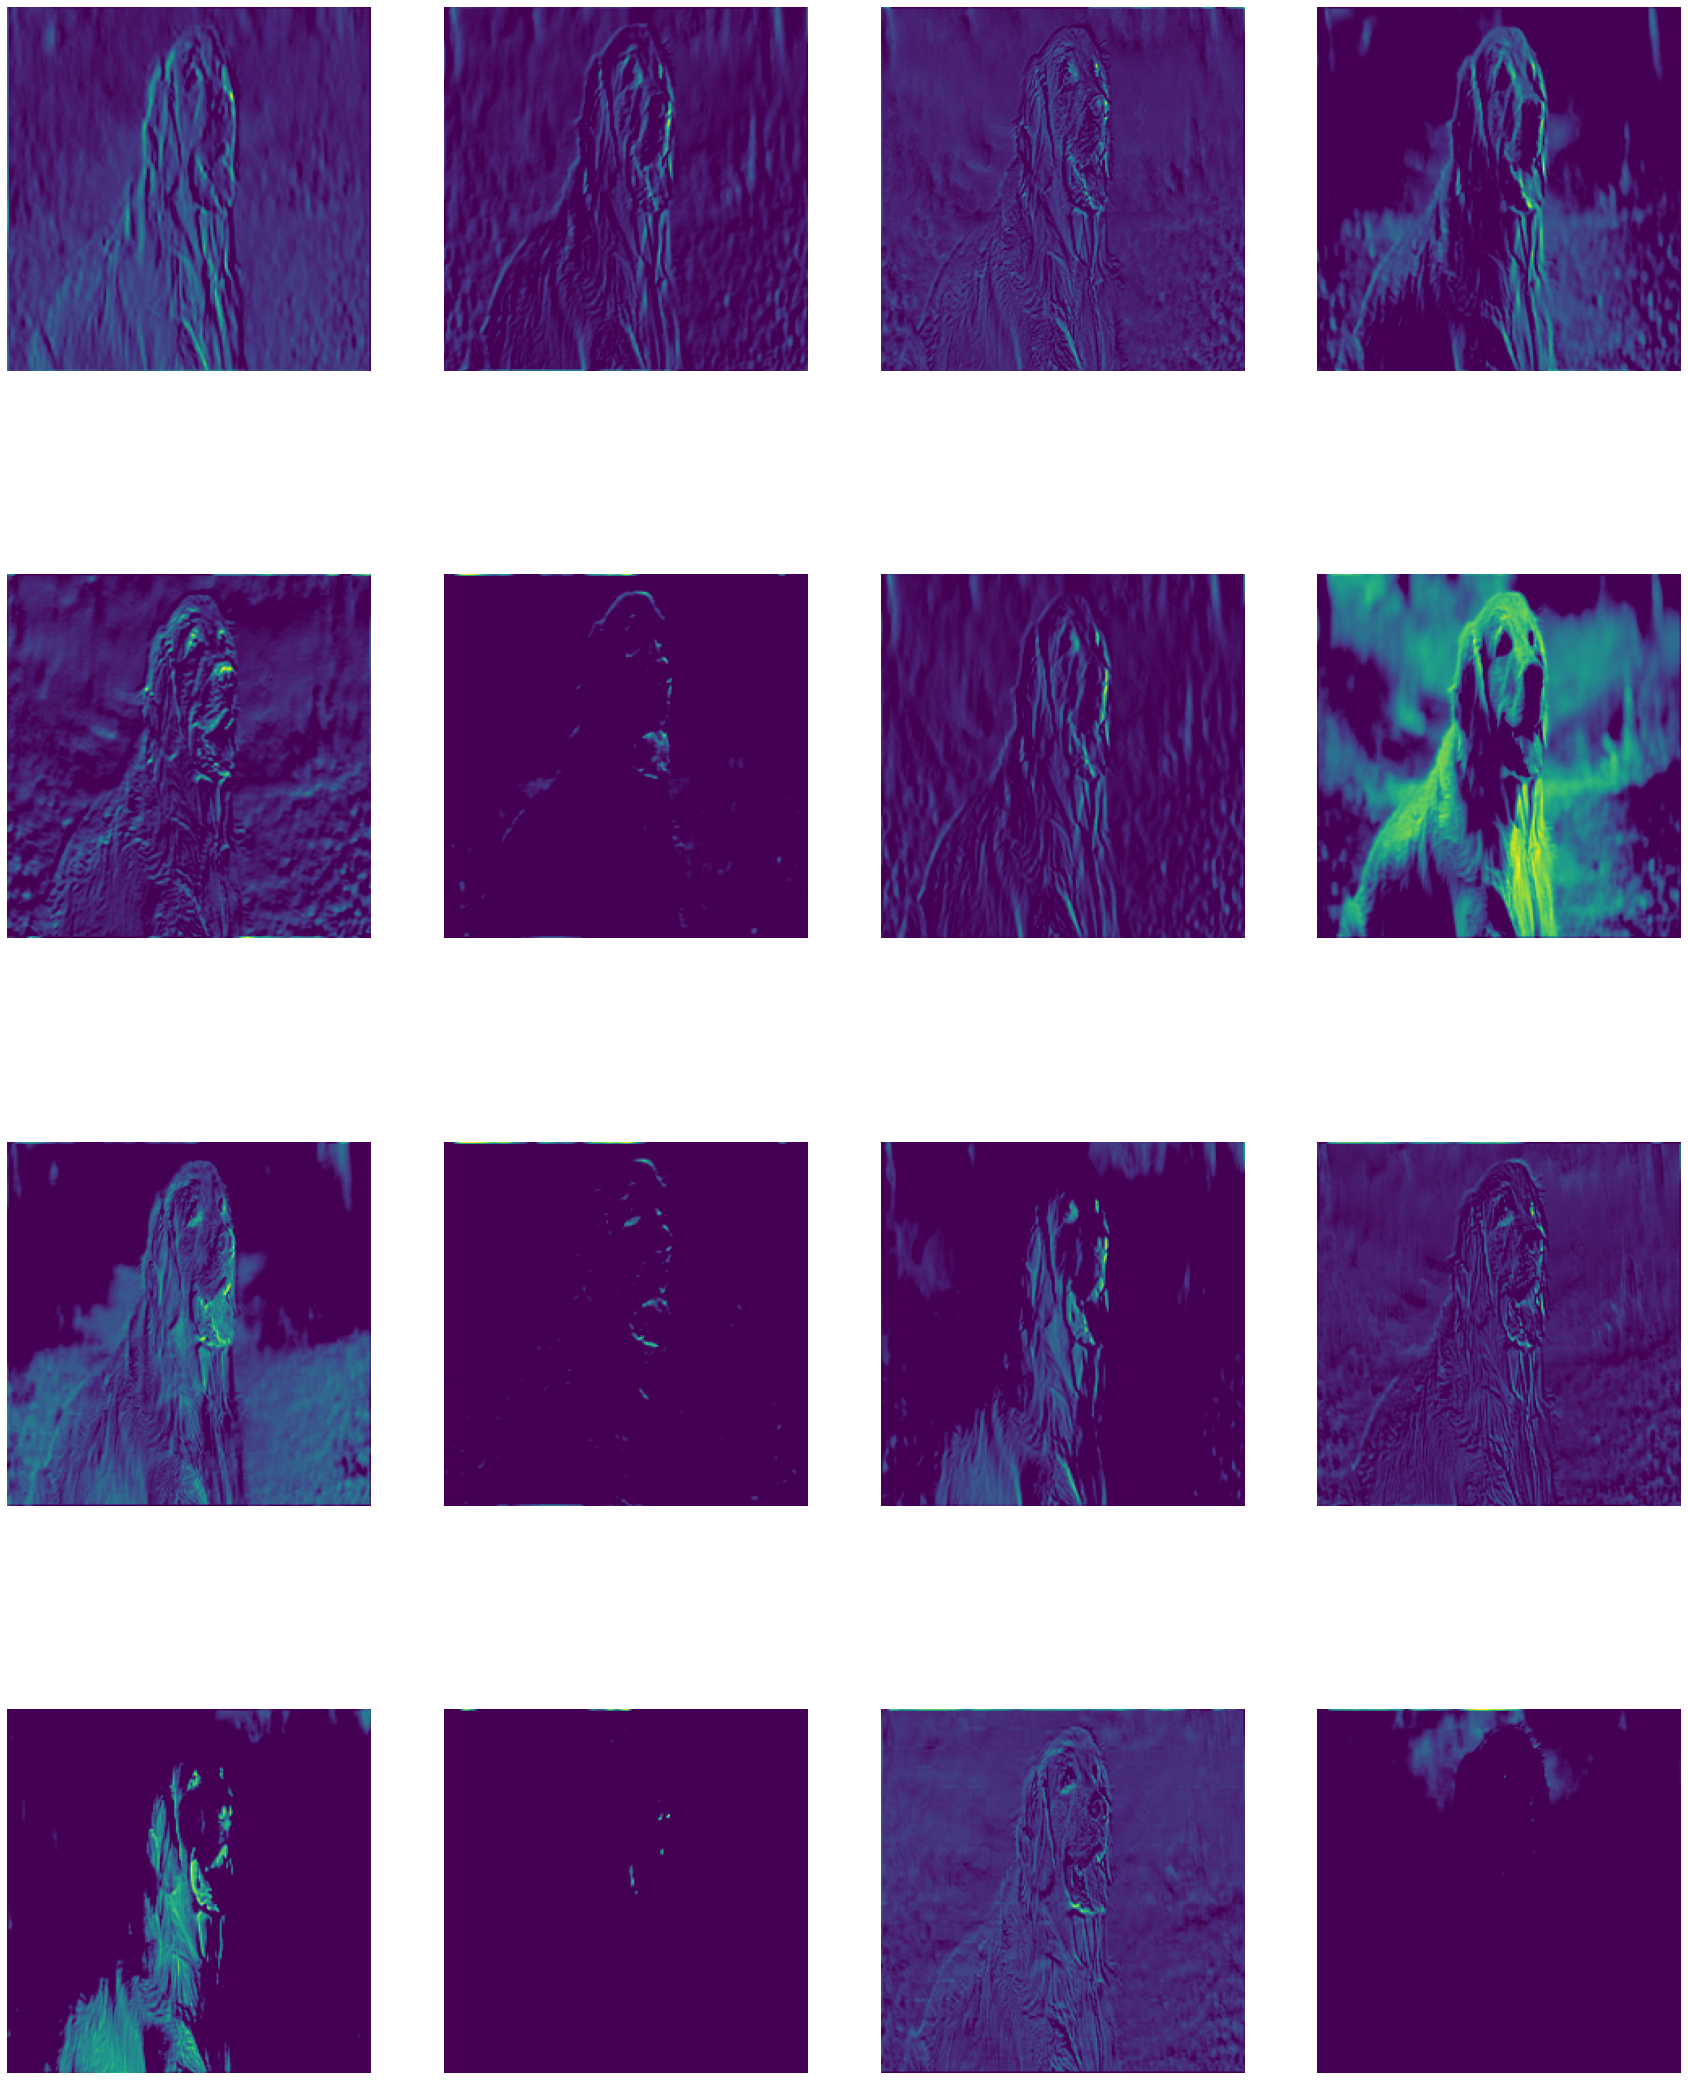

In [ ]:
def filter_outputs(image, layer_to_visualize, num_filters=64):
    if layer_to_visualize < 0:
        layer_to_visualize += 31
    output = None
    name = None
    #image at each layer
    ## get outputs corresponding to the mentioned layer
    for count, layer in enumerate(modules):
        image = layer(image)
        if count == layer_to_visualize: 
            output = image
            name = str(layer)
    
    filters = []
    output = output.data.squeeze()

    ## if num_filters==-1, visualize all the filters
    num_filters = min(num_filters, output.shape[0])
    if num_filters==-1:
        num_filters = output.shape[0]

    for i in range(num_filters):
        filters.append(output[i,:,:])
        
    fig = plt.figure()
    plt.rcParams["figure.figsize"] = (10, 10)

    for i in range(int(np.sqrt(len(filters))) * int(np.sqrt(len(filters)))):
        fig.add_subplot(np.sqrt(len(filters)), np.sqrt(len(filters)),i+1)
        imgplot = plt.imshow(filters[i])
        plt.axis('off')

## if num_filters==-1, visualize all the filters
filter_outputs(img,0,16)    #visualize the outputs of first 16 filters of the 1st layer

The above visualization shows that each filter responds differently to an input which implies that each filter learns and extracts different features from an input.

In [ ]:
random_noise_img = Variable(1e-1 * torch.randn(1, 3, 224, 224), requires_grad=True)

In [ ]:
def get_output_at_nth_layer(inp, layer):
    for i in range(layer):
        inp = modules[i](inp)
    return inp[0]

## dont forget that the system is 0 indexed
target_layer = 18    ## which is this layer Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
inp_img = normalize(Image.open("./dog.jpg"))
inp_img_representation = get_output_at_nth_layer(inp_img, target_layer)

In [ ]:
from torch.optim import SGD
import cnn_utils

#define optimizers for learning the representation of the noise input image
optimizer = SGD([random_noise_img], lr=1e4, momentum=0.9)
alpha_reg_alpha = 6
alpha_reg_lambda = 1e-7
tv_reg_beta = 2
tv_reg_lambda = 1e-8
## Put model into evaluation state
model.eval

<bound method Module.eval of VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, st

In [ ]:
imgs=[]
for i in range(161):
        optimizer.zero_grad()
        
        ## get output at the target layer (not the final layer)
        output = get_output_at_nth_layer(random_noise_img,target_layer)
        
        # Calculate euclidian loss between output image and the target image
        euc_loss = 1e-1 * cnn_utils.euclidian_loss(inp_img_representation.detach(), output)
        
        # regularization
        reg_alpha = alpha_reg_lambda * cnn_utils.alpha_norm(random_noise_img, alpha_reg_alpha)
        reg_total_variation = tv_reg_lambda * cnn_utils.total_variation_norm(random_noise_img,tv_reg_beta)
        
        loss = euc_loss + reg_alpha + reg_total_variation
        loss.backward()
        optimizer.step()
        
        # Generate image every 5 iterations
        if i % 10 == 0:
            print('Iteration:', str(i), 'Loss:', loss.item())
            x = cnn_utils.recreate_image(random_noise_img)
            imgs.append(x)

Iteration: 0 Loss: 0.08902237564325333
Iteration: 10 Loss: 0.050322309136390686
Iteration: 20 Loss: 0.022597987204790115
Iteration: 30 Loss: 0.012905208393931389
Iteration: 40 Loss: 0.008506250567734241
Iteration: 50 Loss: 0.006273658014833927
Iteration: 60 Loss: 0.0052381581626832485
Iteration: 70 Loss: 0.004375407937914133
Iteration: 80 Loss: 0.0038759391754865646
Iteration: 90 Loss: 0.003403842682018876
Iteration: 100 Loss: 0.0034137151669710875
Iteration: 110 Loss: 0.0031715529039502144
Iteration: 120 Loss: 0.0027127957437187433
Iteration: 130 Loss: 0.002873518969863653
Iteration: 140 Loss: 0.00259522651322186
Iteration: 150 Loss: 0.0028657533694058657
Iteration: 160 Loss: 0.002405168954282999


### Visualize the learned representations for the layer "target_layer"

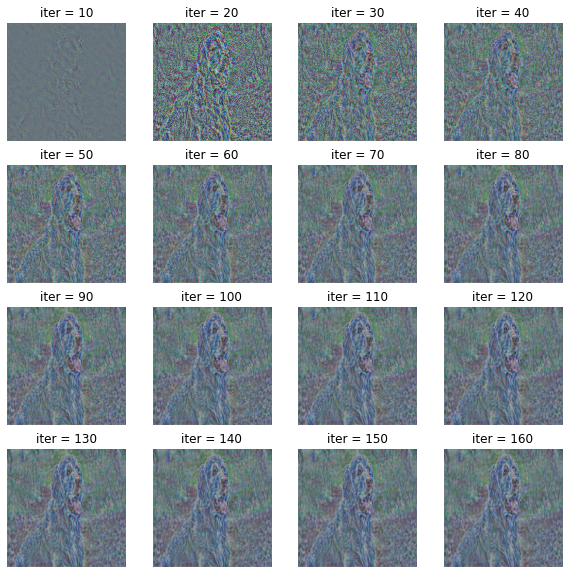

In [ ]:
fig = plt.figure()
plt.rcParams["figure.figsize"] = (10, 10)
for i in range(int(np.sqrt(len(imgs))) * int(np.sqrt(len(imgs)))):
    a = fig.add_subplot(np.sqrt(len(imgs)), np.sqrt(len(imgs)),i+1)
    imgplot = plt.imshow(imgs[i])
    a.set_title("iter = "+ str((i+1)*10))
    plt.axis('off')